Import

In [127]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

Generate data based on $x \sim \mathcal{U}(0,1)$ and $y = t \cdot x + \epsilon$, where $\epsilon \sim \mathcal{N}(0, 0.1)$

In [128]:
n_samples, n_features = 1000, 2
one = np.ones(n_features)
one_norm = one / np.sqrt(n_features)

rng = np.random.RandomState(0)

x_data = rng.rand(n_samples, n_features)
t = np.array([3**i for i in range(n_features)])

y_data = np.asarray([np.matmul(t.T, x) for x in x_data]) 
y_data += rng.normal(0, 1, n_samples)
y_min = np.min(y_data)
y_max = np.max(y_data)

data = np.append(x_data.T, [y_data], axis=0).T

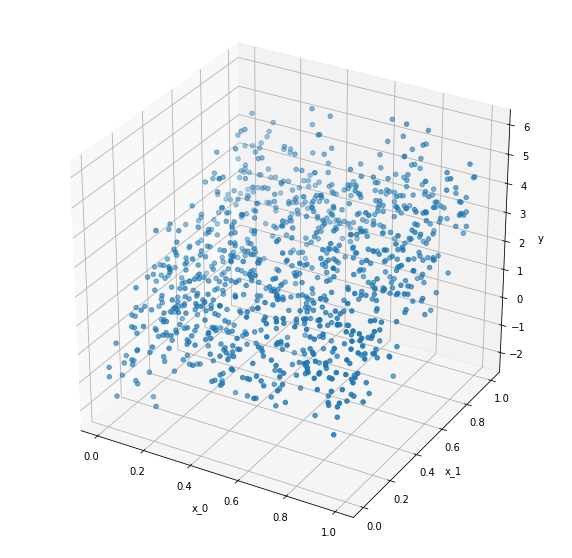

In [129]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(*data.T)
ax.set_xlabel(r'x_0')
ax.set_ylabel(r'x_1')
ax.set_zlabel(r'y');

Define membership function for the truncated data based on a percentage `cutoff`

In [130]:
import scipy.stats as st

In [131]:
cutoff = 0.6

def truncation(y):
    return cutoff < y

def membership(y):
    p = (y - y_min) / (y_max - y_min)
    return truncation(p)

def trunc_norm_sf(mu, sigma):
    """ survival function of truncated normal distribution
    """
    alpha = (cutoff - mu) / sigma
    Z = st.norm(loc=mu, scale=sigma).sf(alpha)
    return st.norm(loc=mu, scale=sigma).sf(alpha) / Z

Define truncated data

In [132]:
truncated_data = data[membership(data[:, -1])]
n_samples_trunc = len(truncated_data)

x_trunc = truncated_data[:, :-1]
y_trunc = truncated_data[:, -1]

l, r, n = 0, 1, 25
lin_x = np.linspace(l, r, n)
mesh_x = np.meshgrid(lin_x, lin_x)
cutoff_y = cutoff * (y_max - y_min) + y_min
c_plane = np.array([[cutoff_y for y, x in slice] for slice in np.transpose(mesh_x)])

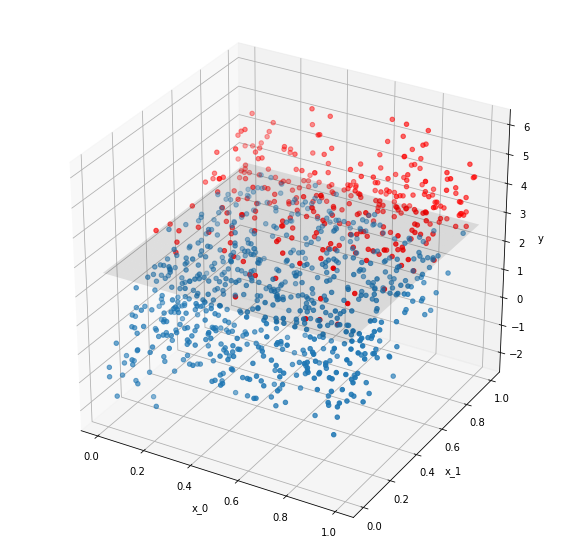

In [133]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(*data[~membership(data[:, -1])].T)
ax.scatter(*truncated_data.T, c='r')
ax.plot_surface(*mesh_x, c_plane, color='k', alpha=0.1)
ax.set_xlabel(r'x_0')
ax.set_ylabel(r'x_1')
ax.set_zlabel(r'y');

Use stochastic gradient descend to fit the full data and the truncated data to a linear model $y = t \cdot x + b$

In [134]:
from sklearn import linear_model

In [135]:
reg = linear_model.SGDRegressor(tol=1e-10, max_iter=10000)
reg.fit(x_data, y_data);

In [136]:
reg_cut = linear_model.SGDRegressor(tol=1e-10, max_iter=10000)
reg_cut.fit(x_trunc, y_trunc);

Not surprisingly, the regression on the truncated data does not generalize to the full data.

In [139]:
reg_surf = np.transpose([[reg.predict([[x, y]]) for y, x in slice] 
                         for slice in np.transpose(mesh_x)])[0]
reg_cut_surf = np.transpose([[reg_cut.predict([[x, y]]) for y, x in slice] 
                             for slice in np.transpose(mesh_x)])[0]

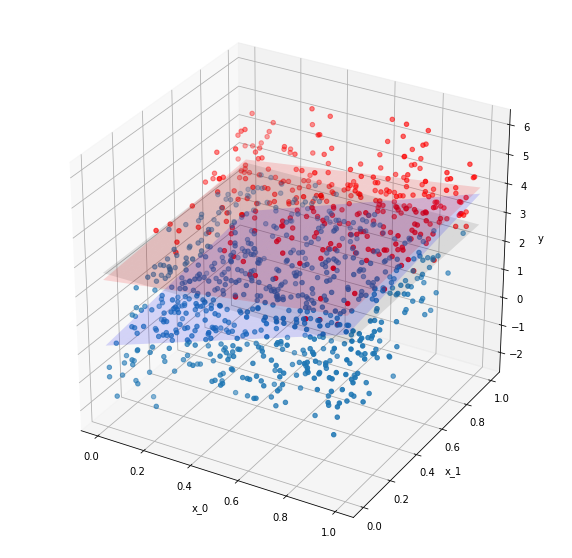

In [140]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(*data[~membership(data[:, -1])].T)
ax.scatter(*truncated_data.T, c='r')
ax.plot_surface(*mesh_x, c_plane, color='k', alpha=0.1)
ax.plot_surface(*mesh_x, reg_surf, color='b', alpha=0.15)
ax.plot_surface(*mesh_x, reg_cut_surf, color='r', alpha=0.15)
ax.set_xlabel(r'x_0')
ax.set_ylabel(r'x_1')
ax.set_zlabel(r'y');

Now, let us approach a way to correct for the truncation as outlined in https://people.csail.mit.edu/costis/truncated-regression.pdf

Assumption 1: (CONSTANT SURVIVAL PROBABILITY ASSUMPTION): Let $(x^{(1)}, y^{(1)}), . . . , (x^{(n)}, y^{(n)})$ be samples from the truncated regression model. There exists a constant $a > 0$ such that
\begin{align}
    \sum\limits_{i = 1}^{n} \log(1/\alpha(x^{(i)}, w^* )) \, x^{(i)} {x^{(i)}}^T
    \preccurlyeq \log(1/a) \sum\limits_{i = 1}^{n} x^{(i)} {x^{(i)}}^T
\end{align}
where $\alpha(x^{(i)}, w^* ) = \mathcal{N}(w \cdot x^{(i)}, 1; S)$ is the survival probability of the truncated set $S$.

In [141]:
from scipy.linalg import eigh

def get_assumption_1_constant(x_trunc, w):
    lhs = np.sum([
        - np.log(trunc_norm_sf(np.matmul(w.T, x), 1)) * np.outer(x, x.T)
        for i, x in enumerate(x_trunc)
    ], axis=0)
    rhs = np.sum([np.outer(x, x.T) for x in x_trunc], axis=0)
    A = np.matmul(lhs, np.linalg.inv(rhs))
    # compute largest eigenvalue
    l = eigh(A, eigvals_only=True, eigvals=(len(A)-1, len(A)-1))[-1]
    return np.exp(-l)

a = get_assumption_1_constant(x_trunc, one)
print(f'a = {a}')

a = 1.0


Assumption 2: (THICKNESS OF COVARIANCE MATRIX OF COVARIATES ASSUMPTION) Let $X = \frac{1}{n}\sum_{i = 1}^n x^{(i)} {x^{(i)}}^T$ for $x^{(i)} \in \mathbb{R}^k$. Then for every $i \in [n]$ it holds that
\begin{align}
    X \succcurlyeq \frac{\log(k)}{n} x^{(i)} {x^{(i)}}^T
\end{align}

Theorem: Let $(x^{(1)}, y^{(1)}),\dots ,(x^{(n)}, y^{(n)})$ be $n$ samples from the truncated regression model with parameters $w$. If Assumptions 1 and 2 hold, then there exists a polynomial time algorithm with success probability at least 2/3, that outputs an estimation $\hat w$ such that
\begin{align}
\lVert \hat w - w \rVert_X \leq {\rm poly}(1/a) \sqrt{\frac{k}{n} \log(n)}
\end{align}
where $X = \frac{1}{n}\sum\limits_{i = 1}^n x^{(i)} {x^{(i)}}^T$.

We need to include a projection step into the vanilla SGD algorithm to insure that for every step the function is strongly convex over the domain, and that the variance of a random sample that approximates the gradient of said function is bounded. For that, we define the projection set
\begin{align}
D_r = \left\{ w \in \mathbb{R}^k \mid \sum\limits_{i=1}^n \left(y^{(i)} - w^T x^{(i)} \right)^2 x^{(i)} {x^{(i)}}^T \preccurlyeq r \sum\limits_{i=1}^n x^{(i)} {x^{(i)}}^T \right\}
\end{align}
We set $r^∗ = 4 \log(2/a) + 7$. Given $x \in \mathbb{R}^k$ we say that $x$ is feasible iff $x \in D_{r^*}$.

In [142]:
from scipy.misc import derivative

In [143]:
R = 4 * np.log(2 / a) + 7

def domain_fun(u, eigvals_only=True):
    nom = np.sum([
        (y_trunc[i] - np.matmul(u.T, x))**2 * np.outer(x, x.T)
        for i, x in enumerate(x_trunc)
    ], axis=0)
    denom = np.sum([np.outer(x, x.T) for x in x_trunc], axis=0)
    A = np.matmul(nom, np.linalg.inv(denom))
    # compute largest eigenvalue and eigenvector
    if eigvals_only:
        ev = eigh(A, eigvals_only=True, eigvals=(len(u)-1, len(u)-1))[-1]
        return ev - R
    else:
        ev, v = eigh(A, eigvals=(len(u)-1, len(u)-1))
        return ev[-1] - R, np.transpose(v)[-1]

def gradient(fun, x):
    """ return gradient of fun w.r.t. x
    """
    grad = np.array([])
    for i, xi in enumerate(x):
        def partial(ui):
            u = np.concatenate([x[:i], [ui], x[i+1:]])
            return fun(u)
        
        grad = np.append(grad, derivative(partial, xi))
    return grad

def grad_domain_fun(u):
    return gradient(domain_fun, u)

def in_domain(u):
    """ check if u is in D_r
    """
    return domain_fun(u) <= 0

def separation_oracle(u, grad_only=False):
    """ return g for which {z | g * (z - u) == 0} is a
        separating hyperplane between u and D_r
        
        Computing the gradient of the domain_fun is equivalent 
        to the explicit method commented below, which is
        equation (16) of the article.
    """
    if grad_only:
        return grad_domain_fun(u)
    else:
        return in_domain(u), grad_domain_fun(u)

# def separation_oracle(u, g_only=False):
#     """ return g for which {z | g * (z - u) == 0} is a
#         separating hyperplane between u and D_r
#
#         Implementation of equation (16) of the article.
#     """
#     l, v = domain_fun(u, eigvals_only=False)
#     
#     inv = np.linalg.inv(np.sum([np.outer(x, x.T) for x in x_trunc], axis=0))
#     P = np.sum([
#         np.matmul(v.T, np.matmul(x, inv))**2 * np.outer(x, x.T)
#         for x in x_trunc
#     ], axis=0)
#     q = -2 * np.sum([
#         y_trunc[i] * np.matmul(v.T, np.matmul(x, inv))**2 * x
#         for i, x in enumerate(x_trunc)
#     ], axis=0)
#     s = np.sum([
#         y_trunc[i]**2 * np.matmul(v.T, np.matmul(x, inv))**2
#         for i, x in enumerate(x_trunc)
#     ], axis=0)
#     
#     g = gradient(lambda z: np.matmul(z.T, np.matmul(P, z)) + np.matmul(q.T, z) + s, u)
#     
#     if g_only:
#         return g
#     else:
#         return l <= 0, g

Let's have a look at the domain function and its gradient:

In [144]:
w_offset = int(2 * np.mean(t)) / 2

l, r, n = -5 + w_offset, 5 + w_offset, 25
lin_w = np.linspace(l, r, n)
domain1d = [domain_fun(x * one) for x in lin_w]
gradient1d = [gradient(lambda u: domain_fun(u * one), [x]) for x in lin_w]

mesh_w = np.meshgrid(lin_w, lin_w)
domain2d = [[domain_fun(np.array([x, y])) for y, x in slice] 
            for slice in np.transpose(mesh_w)]
gradient2d = [[separation_oracle(np.array([x, y]), grad_only=True) for y, x in slice] 
              for slice in np.transpose(mesh_w)]

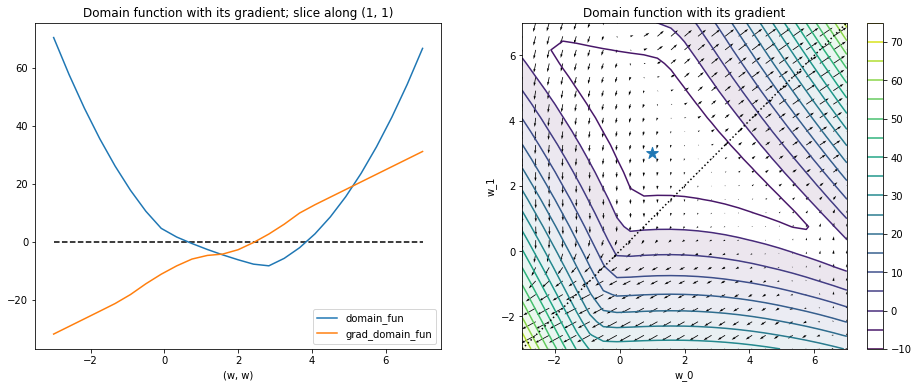

In [184]:
fig = plt.figure(figsize=(16, 6))
ax = fig.add_subplot(121)
ax.plot(lin_w, [0 for x in lin_w], ls='--', c='k')
ax.plot(lin_w, domain1d, label='domain_fun')
ax.plot(lin_w, gradient1d, label='grad_domain_fun')
ax.set_xlabel(r'(w, w)')
ax.set_ylabel(r'')
ax.legend()
ax.set_title('Domain function with its gradient; slice along (1, 1)');

ax = fig.add_subplot(122)
ax.plot(lin_w, lin_w, ls=':', c='k')
ax.scatter(*t, marker='*', s=150)
cntr = ax.contour(*mesh_w, domain2d, levels=15)
fig.colorbar(cntr)
# ax.clabel(cntr, inline=1, fontsize=10)
ax.contourf(*mesh_w, domain2d, levels=cntr.levels[cntr.levels >= 0], 
            cmap=cntr.cmap, alpha=0.1)
ax.quiver(*mesh_w, *np.transpose(gradient2d))
ax.set_xlabel(r'w_0')
ax.set_ylabel(r'w_1')
ax.set_title('Domain function with its gradient');

Now, let us implement the projected gradient descent algorithm

In [146]:
def project_to_domain(w):
    """ return z in D_r for which |z - w| is minimal
    """
    if in_domain(w):
        return w
    
    def norm(tau):
        v = ellipsoid(w, tau)
        if v is not None:
            return np.linalg.norm(v - w)
        else:
            return None
        
    tau = binary_search(norm, left=-1, right=1e3)
    return ellipsoid(w, tau)

def binary_search(fun, left, right, tol=1e-3):
    """ Binary search optimization.
        return lowest value beween left and right 
            for which fun is not None.
    """
    assert left < right
    assert fun(right) is not None
    
    if fun(left) is not None:
        return left
    if right - left < tol:
        return right
    mid = (left + right) / 2
    if fun(mid) is not None:
        return binary_search(fun, left, mid, tol=tol)
    else:
        return binary_search(fun, mid, right, tol=tol)

def ellipsoid(w, tau):
    """ return z for which |z - w| <= tau 
    """
    return ellipsoid_method(w, tau, separation_oracle)

def ellipsoid_method(x, tau, H):
    """ Given ellipsoid {z | (z - x)**2 <= tau},
        and separation oracle H between x and D_r,
        construct a sequence of ellipsoids of decreasing volume
        {z | (z - x[k])**2 <= P[k]}, P[k+1] < P[k], 
        that finds a x[k] in D_r for high enough k, if it exists.
        return x[k] or None
    """
    if tau < 0:
        return None
    
    n = n_features
    eps = 1e-3  # lower bound on volume of space of feasible solutions
    P = tau * np.eye(n)  # initialization
    g = 1e10 * one  # initialization to enter loop
    while np.sqrt(np.matmul(g.T, np.matmul(P, g))) > eps: # feasible solution space not empty
        is_feasible, g = H(x)
        if is_feasible:
            return x
        else:
            g_norm = g / np.sqrt(np.matmul(g.T, np.matmul(P, g)))
            x = x - 1/(n + 1) * np.matmul(P, g_norm)
#             P = P - 2/(n + 1) * np.outer(np.matmul(P, g_norm), np.matmul(g_norm.T, P))
#             P *= n**2/(n**2 - 1)
            P = P + 2/(n + 1) * np.outer(g_norm, g_norm.T)
            P *= 1 - 1/n**2
    return None

def gradient_estimation(r, w, y):
    """ return random sample that estimates gradient of log-likelihood
    """
    in_truncated_set = False
    while not in_truncated_set:
        sample = np.random.randint(len(x_trunc))
        x = x_trunc[sample]
        z = np.random.normal(np.matmul(w.T, x), 1)
        in_truncated_set = membership(z)
    return (y * r - z * x)

def PSGD(data, n_iter, l_rate):
    w = [project_to_domain(4 * one)]
    for i in range(1, n_iter+1):
        sample = np.random.randint(n_samples_trunc)
        x, y = x_trunc[sample], y_trunc[sample]
        v = gradient_estimation(x, w[i-1], y)
        r = w[i-1] + l_rate / i * v
        r_proj = project_to_domain(r)
        w.append(r_proj)
        print(f'{i}/{n_iter}: slope vector = {r_proj}, domain_fun: {domain_fun(r)}', end='\r')
    return w

We will now apply the projected stochastic gradient descent:

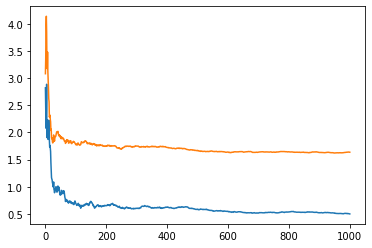

In [147]:
slope = PSGD(truncated_data, n_iter=1000, l_rate=1)
plt.plot(slope);

Let's try to find the zeros of the separation oracle as well as the SGD gradient with good old Newton:

In [171]:
def grad_sgd(w):
    samples = np.random.randint(n_samples_trunc, size=25)
    x, y = x_trunc[samples], y_trunc[samples]
    gradient_est = [gradient_estimation(x_trunc[s], w, y_trunc[s]) for s in samples]
    return np.mean(gradient_est, axis=0)

In [172]:
import scipy.optimize as op

In [178]:
grad_so = op.newton(lambda u: separation_oracle(u, grad_only=True), 2 * one, maxiter=100)
grad_sgd_expect = op.newton(lambda u: grad_sgd(u), 2 * one, maxiter=100)
print(f'{grad_so}, {grad_sgd_expect}, {t}')

[1.32219274 3.61019021], [0.47506711 0.83167101], [1 3]


Let's check how the solution above converged. For that, we compute the expected SGD gradient vector field across $w$. This will take a few minutes ... 

In [124]:
gradient_sgd = [[grad_sgd(np.array([x, y])) for y, x in slice] 
                for slice in np.transpose(mesh_w)]

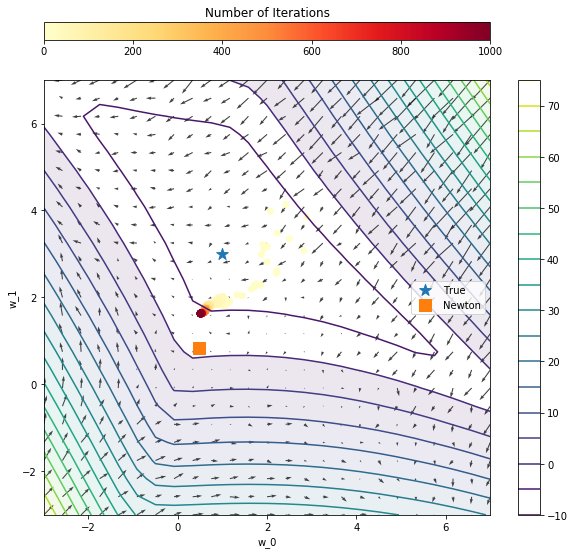

In [182]:
color = list(range(len(slope)))

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111)
cntr = ax.contour(*mesh_w, domain2d, levels=15)
ax.scatter(*t, marker='*', s=150, label='True')
ax.scatter(*grad_sgd_expect, marker='s', s=150, label='Newton')
ax.legend()
ax.quiver(*mesh_w, *np.transpose(gradient_sgd), color='k', alpha=0.75)
ax.set_xlabel(r'w_0')
ax.set_ylabel(r'w_1')
fig.colorbar(cntr)
# ax.clabel(cntr, inline=1, fontsize=10)
ax.contourf(*mesh_w, domain2d, levels=cntr.levels[cntr.levels >= 0], 
            cmap=cntr.cmap, alpha=0.1)
sctr = ax.scatter(*np.transpose(slope), c=color, cmap='YlOrRd')
cbax = fig.add_axes([0.125, 0.95, 0.62, 0.03])  # [left, bottom, width, height]
bar = fig.colorbar(sctr, cax=cbax, orientation='horizontal')
bar.ax.set_title('Number of Iterations');

This plot shows the contours of the domain function, this time with the expectation of the gradient vector field used for the SGD. The true value is markes, as is the one derived from the Newton method. The latter is unstable as the saddle point plateau is rather big.

Now, we can compare again against our data and see how we did:

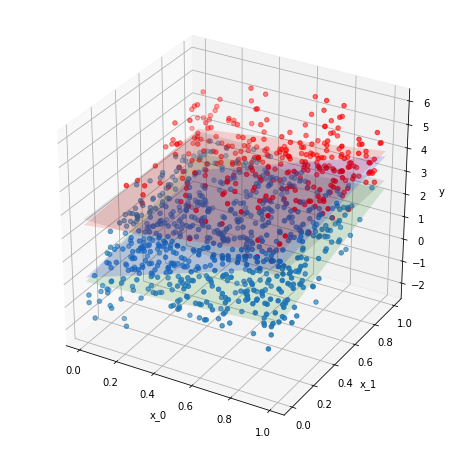

In [149]:
mean_slope = np.mean(slope, axis=0)
psgd_surf = np.array([[np.matmul(mean_slope.T, np.array([x, y])) for y, x in slice] 
                      for slice in np.transpose(mesh_x)])

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(*data[~membership(data[:, -1])].T)
ax.scatter(*truncated_data.T, c='r')
ax.plot_surface(*mesh_x, c_plane, color='k', alpha=0.1)
ax.plot_surface(*mesh_x, reg_surf, color='b', alpha=0.15)
ax.plot_surface(*mesh_x, reg_cut_surf, color='r', alpha=0.15)
ax.plot_surface(*mesh_x, psgd_surf, color='g', alpha=0.15)
ax.set_xlabel(r'x_0')
ax.set_ylabel(r'x_1')
ax.set_zlabel(r'y');

# Deprecated but too pretty to delete

Let's have a look at the gradient estimation. The gradient should flow towards the true optimum.

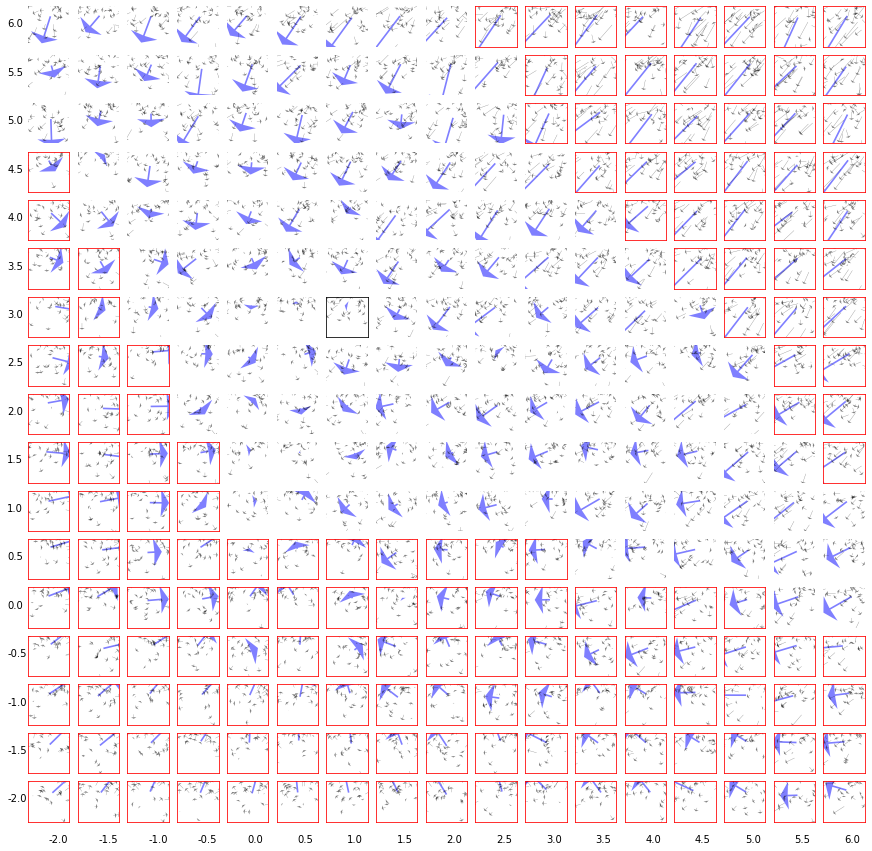

In [117]:
l, r = -4 + w_offset, 4 + w_offset
n = int(2 * (r - l) + 1)
lin_w = np.linspace(l, r, n)
w_list = [np.array([i, j]) for j in reversed(lin_w) for i in lin_w]

fig = plt.figure(figsize=(15, 15))
for i in range(1, n**2 + 1):
    samples = np.random.randint(n_samples_trunc, size=25)
    x, y = x_trunc[samples], y_trunc[samples]
    w = w_list[i-1]
    gradient_est = [gradient_estimation(x_trunc[s], w, y_trunc[s]) for s in samples]
    mean_x = np.mean(x, axis=0)
    mean_grad = np.mean(gradient_est, axis=0)
    
    ax = fig.add_subplot(n, n, i)
    ax.quiver(*mean_x, *mean_grad, scale=2, width=0.04, headwidth=n, color='b', alpha=0.5)
    ax.quiver(*np.transpose(x), *np.transpose(gradient_est), scale=20, headwidth=n, alpha=0.5)
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    if all(w == t):
        ax.set_xticks([])
        ax.set_yticks([])
    else:
        if in_domain(w):
            ax.axis('off')
        else:
            ax.set_xticks([])
            ax.set_yticks([])
            for spine in ax.spines.values():
                spine.set_edgecolor('r')
    # set w 'ticks' on the left
    if i % n == 1:
        ax.text(-0.5, 0.5, f'{w_list[i-1][1]}')
    # set w 'ticks' on the bottom
    if (i - 1) // n == n - 1:
        ax.text(0.5, -0.5, f'{w_list[i-1][0]}')

Shown is the $w$-space, and the box for each $w$ value is the $x$-space. The blue arrows are the average gradients over the $x$-space. The black frame indicates the true $w$ value, whereas the red frames indicated $w$ values outside of the $D_r$ domain.